In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (12, 9)

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

# pandas 결과값의 표현 범위 소수점 2자리수로 변경
pd.options.display.float_format = "{:.2f}".format

# 파일 로드위한 directory 확인 및 현재 경로로 설정
a = os.getcwd()
os.chdir(a)

In [2]:
df = pd.read_csv("funda_train.csv")
submission_df = pd.read_csv("submission.csv")

# Data Processing - Train data

## 년/월 추출

In [3]:
# .str.split으로 년/월 추출

# year
df['transacted_year'] = df['transacted_date'].str.split('-', expand = True).iloc[:, 0].astype(int)

# month
df['transacted_month'] = df['transacted_date'].str.split('-', expand = True).iloc[:, 1].astype(int)
df.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount,transacted_year,transacted_month
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14,2016,6
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14,2016,6
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00,2016,6
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14,2016,6
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00,2016,6


- transacted_date의 시작점이 2016년 6월 1일 이므로 transacted_year에서 2016을 빼고 'month'를 기준으로 데이터를 분류하는 index번호처럼 생성
계산 방식은 다음과 같다.

```python
standard_t = (연도-2016)*12 + '월'
```
- 2016년의 경우 6월 =6, 7월 =7
- 2017년의 경우 1월 = 12, 2월 = 24
- 위와 같이 각 연도별 월을 구분지을 수 있게 가공된다.

## 기준 시점이 될 std_mth (= standard_month) 생성

In [4]:
# 데이터 병합을 위해 시간 데이터를 standard_t 로 변경하고, 불필요한 컬럼은 drop
df['std_mth'] = (df['transacted_year'] - 2016) * 12 + df['transacted_month']
df.drop(['transacted_year', 'transacted_month', 'transacted_date', 'transacted_time'], axis = 1, inplace = True)

In [5]:
df['std_mth'].unique()

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38])

## 업종 특성, 지역, 할부 평균 - 파생변수 생성

### installment_term - 매장별 평균 할부 비율

- EDA에서 본 바와 같이 대부분이 일시불이므로 일시불 / 할부로 범주를 이원화 하여 사용 (전체 할부 개월 수 로 하기엔 너무 범위가 큼)
- 다만, 단순 할부 여부는 동일 매장에서 결제 건수가 여러건 발생 하므로 T/F로 입력할 수가 없다. -> 매장별 평균 할부개월 비율로 전처리

In [6]:
df['installment_term'] = (df['installment_term'] > 0).astype(int) # bool to int (True=1, False=0)
df['installment_term'].value_counts()

0    6327632
1     228981
Name: installment_term, dtype: int64

In [7]:
# 각 매장 기준으로 할부 기간의 평균 계산
installment_term_per_store = df.groupby(['store_id'])['installment_term'].mean()
installment_term_per_store.head()

store_id
0   0.04
1   0.00
2   0.08
4   0.00
5   0.08
Name: installment_term, dtype: float64

In [8]:
# 결측치 확인
pd.DataFrame(installment_term_per_store).isnull().sum()

installment_term    0
dtype: int64

### region - group by로 데이터 셋팅

- 범주형이지만, 종류가 너무 많아 dummy 하여 사용하기는 어려움 -> 활용을 위해 파생변수 생성 필요 (group by)
- 결측치가 2042766 개 존재함
- 결측치를 drop하기에는 너무 많은 데이터 -> 전처리를 통해 group by에 포함되도록 해야 함

In [9]:
# 결측치 전처리
df['region'].fillna('미분류', inplace = True)
df['region'].value_counts().head()

미분류       2042766
경기 수원시     122029
충북 청주시     116766
경남 창원시     107147
경남 김해시     100673
Name: region, dtype: int64

In [10]:
# 결측치 재확인
df['region'].value_counts().isnull().sum()

0

### type_of_business - 데이터 셋팅
- 범주형이지만, 종류가 너무 많아(145개) dummy 하여 사용하기는 어려움 -> 활용을 위해 파생변수 생성 필요 (group by)
- 결측치가 3952609 개 존재함
- 결측치를 drop하기에는 너무 많은 데이터 -> 전처리를 통해 group by에 포함되도록 해야 함

In [11]:
# groupby에 결측을 포함시키기 위해, 결측을 문자로 대체
df['type_of_business'].fillna('미분류', inplace = True)
df['type_of_business'].value_counts().head()

미분류        3952609
한식 음식점업     745905
두발 미용업      178475
의복 소매업      158234
기타 주점업      102413
Name: type_of_business, dtype: int64

In [12]:
# 결과 재확인
df['type_of_business'].value_counts().isnull().sum()

0

## 불필요한 변수 제거
- card_id, card_company는 특징으로 사용하기에는 범주가 너무 세밀하고, 특징으로서 유의하지 않을 것이라 판단되므로 drop

In [13]:
df.drop(['card_id', 'card_company'], axis = 1, inplace = True)

## 중복 데이터 처리

In [14]:
# 'store_id', 'region', 'type_of_business', 'std_mth'를 기준으로 중복 제거
train_df = df.drop_duplicates(subset = ['store_id', 'region', 'type_of_business', 'std_mth'])[['store_id', 'region', 'type_of_business', 'std_mth']]
train_df.head()

,store_id,region,type_of_business,std_mth
0,0,미분류,기타 미용업,6
145,0,미분류,기타 미용업,7
323,0,미분류,기타 미용업,8
494,0,미분류,기타 미용업,9
654,0,미분류,기타 미용업,10


## 평균 할부율 입력 to train_df

In [15]:
train_df['평균할부율'] = train_df['store_id'].replace(installment_term_per_store.to_dict())

## std_mth(기준월)의 -1, -2, -3 시점에 대한 매장별/지역별/ 업종별 매출 파생변수 생성

- df1에서는 시점 t를, 다른 데이터에서는 시점 t+1 or t-1 을 붙여야 되는 상황
- t가 유니크 하다면, df2를 shift()해서 공백을 만든 뒤 concat을 하면 된다. (시계열 데이터에서 많이 사용)
- t가 유니크 하지 않은 경우는 새로운 변수( e.g: t_1)을 만들어서 merge한다.

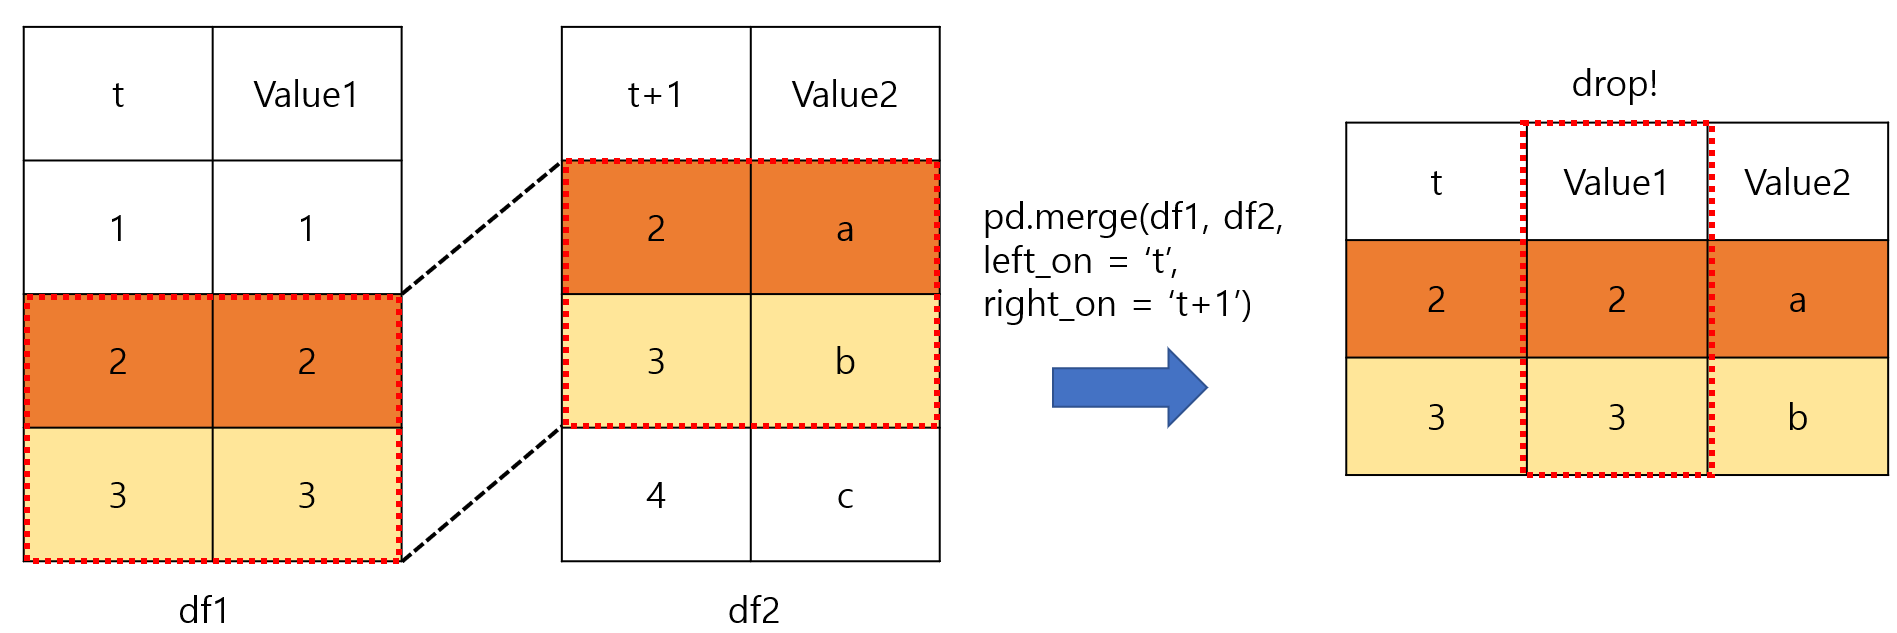

---
- 단, std_mth는 각 매장별로 값이 존재하고, 필요한 값은 기준 월(std_mth)을 중심으로 -1, -2, -3 개월의 매출 값이다.
- 이를 위해 for문을 사용하여 i = 1, 2, 3 일때 각각 t_{i} 값이 들어가는 변수를 만들어서 병합할 것이다.
- 중복 방지를 위해 병합한 변수명 변경 및 drop 작업도 함께 수행한다.

### 각 시점별 매장의 월 매출 (파생변수)

##### 각 store당 월별 amount 계산

- standard_t (월): 6(2016년 6월) ~ 38 (2019년 2월)
- 즉, store_id가 0이라는 매장의 standard_t가 6일때의 매출 , 7일때의 매출... 38일때의 매출을 각각 입력

In [16]:
# store_id와 standard_t에 따른 amount 합계 계산: total_amt_per_mth_and_store
total_amt_per_mth_and_store = df.groupby(['store_id', 'std_mth'], as_index = False)['amount'].sum()
total_amt_per_mth_and_store.head()

,store_id,std_mth,amount
0,0,6,747000.00
1,0,7,1005000.00
2,0,8,871571.43
3,0,9,897857.14
4,0,10,835428.57


- group by의 경우 지정한 조건에 해당하는 값이 없으면 건너뛴다.
- 각 지점별로 '모든 월' 에 대한 amount가 들어가야 하므로, 매장별 매출에서 값이 생략된 월들은 0으로 값을 넣어줘야 한다.
- 그렇지 않을 경우 다른 데이터와 merge 할 경우 에러 발생, 혹은 잘못된 값이 입력될 수 있다.

매장별로 결측된 월이 있는지 확인

In [17]:
total_amt_per_mth_and_store.groupby(['store_id'])['std_mth'].count()

store_id
0       33
1       33
2       33
4       33
5       33
        ..
2132    31
2133    32
2134    26
2135    31
2136    22
Name: std_mth, Length: 1967, dtype: int64

- 몇몇 store_id에서 누락된 값이 보인다.
- group by에서 생략된 값이 실제 매출이 발생했는데 단순 누락된 값인지, 매장 운영이 되지 않은 기간이어서 0인건지 확인이 어렵다.
- 이를 위해 pivot_table 활용
---
- 누락된 값이 연속적인 경우만 있다면 매출이 발생하지 않은 것으로 가정 하여 0으로 채운다.
    - e.g) 시작점은 2016년 6월이지만, 누락된 매장들은 시작점 보다 늦게 개점하여 누락된 경우


- 누락된 값이 불연속적이라면, 매출값이 누락된 것이라 가정하고 누락된 값의 '전/후' 값으로 채워넣는다.

In [19]:
# pivot_table로 nan값의 분포 형태 확인
check_nan_amount = pd.pivot_table(df, values = 'amount', index = 'store_id', columns = 'std_mth', aggfunc = 'sum')
check_nan_amount

std_mth,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,747000.00,1005000.00,871571.43,897857.14,835428.57,697000.00,761857.14,585642.86,794000.00,720257.14,685285.71,744428.57,682000.00,728285.71,749000.00,840857.14,600571.43,630857.14,812714.29,643142.86,685285.71,848428.57,636142.86,686428.57,707285.71,758714.29,679857.14,651857.14,739000.00,676000.00,874571.43,682857.14,515285.71
1,137214.29,163000.00,118142.86,90428.57,118071.43,111857.14,115571.43,129642.86,160214.29,168428.57,152571.43,107500.00,110357.14,132571.43,107642.86,131357.14,80142.86,110142.86,100714.29,109571.43,94214.29,108357.14,108857.14,80500.00,78285.71,100785.71,92142.86,63571.43,95000.00,80785.71,85285.71,148285.71,77428.57
2,260714.29,82857.14,131428.57,142857.14,109714.29,198571.43,160000.00,180714.29,154285.71,43571.43,201428.57,186428.57,120571.43,207142.86,190000.00,232857.14,266714.29,252857.14,238571.43,299714.29,312857.14,189714.29,283571.43,472857.14,354285.71,689285.71,457857.14,480714.29,510000.00,185428.57,340714.29,407857.14,496857.14
4,733428.57,768928.57,698428.57,936428.57,762714.29,859571.43,1069857.14,689142.86,1050142.86,970285.71,1085171.43,1035857.14,894142.86,1027285.71,1186857.14,972571.43,1060571.43,1189142.86,1010142.86,831571.43,651000.00,908000.00,792214.29,775428.57,881285.71,1050928.57,849285.71,698142.86,828428.57,883000.00,923857.14,944857.14,882285.71
5,342500.00,432714.29,263500.00,232142.86,211571.43,182085.71,147571.43,120957.14,186428.57,169000.00,312857.14,235342.86,475857.14,410914.29,297714.29,291428.57,396157.14,399285.71,441557.14,388428.57,316785.71,370142.86,297857.14,443857.14,563714.29,607071.43,482885.71,195000.00,324928.57,383300.00,399571.43,323000.00,215514.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,nan,nan,281142.86,783428.57,822000.00,941142.86,731142.86,684571.43,701000.00,742428.57,624614.29,566857.14,742857.14,865285.71,898428.57,787857.14,531857.14,1095000.00,1014071.43,580785.71,703857.14,909142.86,938428.57,670571.43,757857.14,753428.57,524142.86,637714.29,938571.43,729857.14,474285.71,571142.86,630428.57
2133,85000.00,367857.14,743571.43,494714.29,178571.43,124285.71,36285.71,31857.14,145114.29,313128.57,300685.71,384057.14,524342.86,425342.86,438257.14,493757.14,421214.29,646628.57,601171.43,433414.29,277342.86,308485.71,484071.43,626071.43,395700.00,421614.29,548942.86,310971.43,192700.00,84714.29,nan,84000.00,116285.71
2134,nan,nan,nan,nan,nan,393000.00,678214.29,459071.43,463428.57,446285.71,363571.43,580285.71,486857.14,503642.86,467785.71,431642.86,248714.29,355714.29,374142.86,313785.71,171857.14,245571.43,72357.14,216142.86,209785.71,140714.29,nan,nan,84428.57,60785.71,4285.71,209428.57,166000.00


- pivot table을 통해 보았을때, '월' 의 중간 중간 nan값이 발생하는 것으로 보아, 실제 매출은 발생하였으나 누락된 데이터 일 것이라 가정
- nan값을 바로 앞, 뒤 standard_t의 매출로 채워 넣는다.

In [20]:
# 발생한 nan값을 바로 앞/뒤의 값으로 채워넣는다.
# method = 'ffill', axis = 1 #전
# method = 'bfill', axis = 1 #후

total_amt_per_mth_and_store = check_nan_amount.fillna(method = 'ffill', axis = 1).fillna(method = 'bfill', axis = 1)
total_amt_per_mth_and_store.head(10)

std_mth,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,747000.00,1005000.00,871571.43,897857.14,835428.57,697000.00,761857.14,585642.86,794000.00,720257.14,685285.71,744428.57,682000.00,728285.71,749000.00,840857.14,600571.43,630857.14,812714.29,643142.86,685285.71,848428.57,636142.86,686428.57,707285.71,758714.29,679857.14,651857.14,739000.00,676000.00,874571.43,682857.14,515285.71
1,137214.29,163000.00,118142.86,90428.57,118071.43,111857.14,115571.43,129642.86,160214.29,168428.57,152571.43,107500.00,110357.14,132571.43,107642.86,131357.14,80142.86,110142.86,100714.29,109571.43,94214.29,108357.14,108857.14,80500.00,78285.71,100785.71,92142.86,63571.43,95000.00,80785.71,85285.71,148285.71,77428.57
2,260714.29,82857.14,131428.57,142857.14,109714.29,198571.43,160000.00,180714.29,154285.71,43571.43,201428.57,186428.57,120571.43,207142.86,190000.00,232857.14,266714.29,252857.14,238571.43,299714.29,312857.14,189714.29,283571.43,472857.14,354285.71,689285.71,457857.14,480714.29,510000.00,185428.57,340714.29,407857.14,496857.14
4,733428.57,768928.57,698428.57,936428.57,762714.29,859571.43,1069857.14,689142.86,1050142.86,970285.71,1085171.43,1035857.14,894142.86,1027285.71,1186857.14,972571.43,1060571.43,1189142.86,1010142.86,831571.43,651000.00,908000.00,792214.29,775428.57,881285.71,1050928.57,849285.71,698142.86,828428.57,883000.00,923857.14,944857.14,882285.71
5,342500.00,432714.29,263500.00,232142.86,211571.43,182085.71,147571.43,120957.14,186428.57,169000.00,312857.14,235342.86,475857.14,410914.29,297714.29,291428.57,396157.14,399285.71,441557.14,388428.57,316785.71,370142.86,297857.14,443857.14,563714.29,607071.43,482885.71,195000.00,324928.57,383300.00,399571.43,323000.00,215514.29
6,568857.14,568857.14,568857.14,1440142.86,1238857.14,1055428.57,926857.14,885642.86,800357.14,930714.29,855071.43,1029785.71,1071571.43,1037214.29,1054857.14,937857.14,1216285.71,1833571.43,2429500.00,2147714.29,2113357.14,2348714.29,1876857.14,1808357.14,1752285.71,1583785.71,1628785.71,2074071.43,1907642.86,2389142.86,2230285.71,2015500.00,2463857.14
7,107857.14,107857.14,107857.14,375642.86,323642.86,345000.00,291428.57,231614.29,271357.14,249857.14,131500.00,118642.86,53285.71,372285.71,183000.00,527857.14,218214.29,817714.29,750645.71,761571.43,636571.43,339857.14,1039357.14,265714.29,419542.86,462842.86,423128.57,320328.57,420028.57,314385.71,302414.29,136471.43,57971.43
8,192571.43,192571.43,192571.43,192571.43,192571.43,192571.43,735500.00,467857.14,475642.86,603500.00,1074642.86,1144571.43,1030928.57,1375571.43,1078928.57,984500.00,896785.71,514500.00,552214.29,618785.71,461714.29,744500.00,867071.43,1837428.57,1359857.14,1213542.86,1086000.00,1369557.14,1272071.43,1260557.14,1157257.14,1134671.43,1298328.57
9,107142.86,107142.86,107142.86,107142.86,107142.86,637142.86,603571.43,225428.57,287142.86,344428.57,352857.14,208571.43,178571.43,761714.29,535000.00,715714.29,672142.86,634285.71,333714.29,295428.57,628285.71,318571.43,1016857.14,638571.43,276571.43,340000.00,254285.71,926571.43,871428.57,692857.14,662857.14,370000.00,405714.29


- train_df와 병합을 위해 pivot_table 형태인 total_amt_per_mth_and_store 테이블을 stack() 함수를 사용해 동일한 형태의 DataFrame으로 변경

- stack() : column 과 row를 바꾸는 함수
- 위의 pivot_table 기준으로보면 store_id, std_mth, amount가 column이 되고, 기존 columns 별로 입력되있던 값이 row가 된다.

In [21]:
total_amt_per_mth_and_store = total_amt_per_mth_and_store.stack().reset_index() # index 번호 새로 부여

In [22]:
total_amt_per_mth_and_store

,store_id,std_mth,0
0,0,6,747000.00
1,0,7,1005000.00
2,0,8,871571.43
3,0,9,897857.14
4,0,10,835428.57
...,...,...,...
64906,2136,34,2012214.29
64907,2136,35,2135428.57
64908,2136,36,2427428.57
64909,2136,37,1873642.86


In [23]:
# amount로 컬럼명 변경
total_amt_per_mth_and_store.rename({0:"amount"}, axis = 1, inplace = True)
total_amt_per_mth_and_store.head(3)

,store_id,std_mth,amount
0,0,6,747000.00
1,0,7,1005000.00
2,0,8,871571.43


##### 매장별 월 매출 + train_df

In [24]:
# std_mth + i (i = 1, 2, 3) 시점의 부착
# train_df의 std_mth는 total_amt_per_mth_and_store의 std_mth-i와 부착되어야 하므로, total_amt_per_mth_and_store의 std_mth에 i를 더함

for i in range(1, 4): 
    # i값에 따른 새로운 변수 생성
    total_amt_per_mth_and_store['std_mth_{}'.format(i)] = total_amt_per_mth_and_store['std_mth'] + i
    
    # 두 테이블 데이터 결합
    # 두 table에 모두 std_mth가 존재하므로 drop
    train_df = pd.merge(train_df, total_amt_per_mth_and_store.drop('std_mth', axis = 1), left_on = ['store_id', 'std_mth'], right_on = ['store_id', 'std_mth_{}'.format(i)])
    
    # 변수명 변경: 다음 loop에서 merge할때 중복 column 때문에 _x, _y가 생기는 것 방지
    train_df.rename({"amount":"{}_before_amount".format(i)}, axis = 1, inplace = True)
    
    #필요없어진 변수 drop
    train_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    total_amt_per_mth_and_store.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    
train_df.head()

,store_id,region,type_of_business,std_mth,평균할부율,1_before_amount,2_before_amount,3_before_amount
0,0,미분류,기타 미용업,9,0.04,871571.43,1005000.00,747000.00
1,0,미분류,기타 미용업,10,0.04,897857.14,871571.43,1005000.00
2,0,미분류,기타 미용업,11,0.04,835428.57,897857.14,871571.43
3,0,미분류,기타 미용업,12,0.04,697000.00,835428.57,897857.14
4,0,미분류,기타 미용업,13,0.04,761857.14,697000.00,835428.57


- std_mth의 시작점이 6 -> 9로 바뀐다. (for문이 적용되고 merge되면서 사라진 것)
- 6월의 amount는 3_before_amount에 입력되어 있다.
- 일괄적으로 +3이 된 것이기 때문에 ok
- std_mth 9(=16년 9월)를 기준으로 보았을때
    - 1_before_amount는 16년 8월, 2_before_amount는 16년 7월, 3_before_amount는 16년 6월을 의미한다.
    
    
    
- 전체적으로 본다면 2016년 6월에 대한 특징 데이터는 소실된다. 하지만 반대로 다른 시점에 특성을 구분할 수 있는 데이터가 늘어남  
---
- i값을 3으로 한 이유 :

    1) 예측해야 하는 값이 3개월 평균 이기 때문
    
    2) i가 클수록 유실되는 데이터량이 많아져서 최소화 하기 위해( 1)의 기간도 감안 )

#### 각 시점별 지역의 월 매출 (파생변수)

##### region(지역) 별 평균 매출 계산

In [25]:
#지역별 매장을 분류(dict) & 중복제거
store_to_region = df[['store_id', 'region']].drop_duplicates().set_index(['store_id'])['region'].to_dict() 

# store_id를 region으로 대체 -> 위에서 사용한 코드 동일하게 사용 가능
total_amt_per_mth_and_store['region'] = total_amt_per_mth_and_store['store_id'].replace(store_to_region)

# 지역별 평균 매출 계산
# total_amt_per_mth_and_store에 region이란 컬럼 추가 후 amt_mean_per_std_mth_and_region 테이블로 변경
amt_mean_per_std_mth_and_region = total_amt_per_mth_and_store.groupby(['region', 'std_mth'], as_index = False)['amount'].mean()

In [26]:
amt_mean_per_std_mth_and_region.head(3)

,region,std_mth,amount
0,강원 강릉시,6,623271.75
1,강원 강릉시,7,501311.43
2,강원 강릉시,8,508130.79


- 위에서 store_id의 누락치를 처리하는 과정에서 nan값을 모두 처리함
- 즉, store_id를 region으로 대체한 것이기 때문에, pivot_table & stack 등을 통한 결측치 제거는 하지 않아도 됨.

##### train_df + amt_mean_per_std_mth_and_region

In [27]:
# std_mth + i (i = 1, 2, 3)

for i in range(1, 4):
    amt_mean_per_std_mth_and_region['std_mth_{}'.format(i)] = amt_mean_per_std_mth_and_region['std_mth'] + i
    train_df = pd.merge(train_df, amt_mean_per_std_mth_and_region.drop('std_mth', axis = 1), left_on = ['region', 'std_mth'], right_on = ['region', 'std_mth_{}'.format(i)])
    train_df.rename({"amount":"{}_before_amount_of_region".format(i)}, axis = 1, inplace = True)
    
    # 계산에 사용되고 필요없어진 데이터 drop
    train_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    amt_mean_per_std_mth_and_region.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)    
    
train_df.head()

,store_id,region,type_of_business,std_mth,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region
0,0,미분류,기타 미용업,9,0.04,871571.43,1005000.00,747000.00,761987.42,756108.67,739654.07
1,1,미분류,미분류,9,0.00,118142.86,163000.00,137214.29,761987.42,756108.67,739654.07
2,2,미분류,미분류,9,0.08,131428.57,82857.14,260714.29,761987.42,756108.67,739654.07
3,5,미분류,의복 액세서리 및 모조 장신구 도매업,9,0.08,263500.00,432714.29,342500.00,761987.42,756108.67,739654.07
4,7,미분류,미분류,9,0.01,107857.14,107857.14,107857.14,761987.42,756108.67,739654.07


#### 각 시점별 업종의 월 매출 (파생변수)

##### type_of_business별 평균 매출 계산

In [28]:
##업종별 매장을 분류(dict) & 중복제거
store_to_type_of_business = df[['store_id', 'type_of_business']].drop_duplicates().set_index(['store_id'])['type_of_business'].to_dict()

# store_id를 type_of_business으로 대체 -> 위에서 사용한 코드 동일하게 사용 가능
total_amt_per_mth_and_store['type_of_business'] = total_amt_per_mth_and_store['store_id'].replace(store_to_type_of_business)

# 지역별 평균 매출 계산
amount_mean_per_mth_and_type_of_business = total_amt_per_mth_and_store.groupby(['type_of_business', 'std_mth'], as_index = False)['amount'].mean()

##### amount_mean_per_mth_and_type_of_business + train_df

In [29]:
# std_mth + i (i = 1, 2, 3)
# train_df의 std_mth는 total_amt_per_mth_and_store의 std_mth-i와 merge 해야하므로, total_amt_per_mth_and_store의 std_mth에 i를 더한다.

for i in range(1, 4):
    amount_mean_per_mth_and_type_of_business['std_mth_{}'.format(i)] = amount_mean_per_mth_and_type_of_business['std_mth'] + i
    train_df = pd.merge(train_df, amount_mean_per_mth_and_type_of_business.drop('std_mth', axis = 1), left_on = ['type_of_business', 'std_mth'], right_on = ['type_of_business', 'std_mth_{}'.format(i)])
    train_df.rename({"amount":"{}_before_amount_of_type_of_business".format(i)}, axis = 1, inplace = True)
    
    # 계산에 사용되고 필요없어진 데이터 drop
    train_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    amount_mean_per_mth_and_type_of_business.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)       
    
train_df.head()

,store_id,region,type_of_business,std_mth,평균할부율,1_before_amount,2_before_amount,3_before_amount,1_before_amount_of_region,2_before_amount_of_region,3_before_amount_of_region,1_before_amount_of_type_of_business,2_before_amount_of_type_of_business,3_before_amount_of_type_of_business
0,0,미분류,기타 미용업,9,0.04,871571.43,1005000.00,747000.00,761987.42,756108.67,739654.07,761025.00,804979.76,679950.00
1,792,미분류,기타 미용업,9,0.22,681142.86,880857.14,733714.29,761987.42,756108.67,739654.07,761025.00,804979.76,679950.00
2,23,경기 안양시,기타 미용업,9,0.05,879242.86,730857.14,845285.71,828831.71,588733.00,955973.29,761025.00,804979.76,679950.00
3,192,경기 화성시,기타 미용업,9,0.10,579000.00,523428.57,551142.86,1234460.01,1227920.91,1180455.31,761025.00,804979.76,679950.00
4,536,서울 광진구,기타 미용업,9,0.01,96285.71,79857.14,99857.14,3786819.95,3397972.56,3524074.62,761025.00,804979.76,679950.00


## label 부착하기 ( std_mth +1, std_mth+2, std_mth+3)

- label 은 기준월 (std_mth) 에서 각각 +1, +2, +3 인 시점에 대한 amount는 예측 모델을 통해 파악해야 하는 값이다.
- 이후 에는 model 학습을 위한 데이터 전처리가 들어가기 때문에, raw data인 현상황에서 +1, +2, +3 인 시점의 amount를 입력해 두는 것이 추후 작업에서 유용하다.

In [30]:
# 불필요한 컬럼 drop (중복 컬럼 방지)
total_amt_per_mth_and_store.drop(['region', 'type_of_business'], axis = 1, inplace = True)

# std_mth - i (i = 1, 2, 3)
for i in range(1, 4):
    total_amt_per_mth_and_store['std_mth_{}'.format(i)] = total_amt_per_mth_and_store['std_mth'] - i   
    train_df = pd.merge(train_df, total_amt_per_mth_and_store.drop('std_mth', axis = 1), left_on = ['store_id', 'std_mth'], right_on = ['store_id', 'std_mth_{}'.format(i)])
    train_df.rename({"amount": "Y_{}".format(i)}, axis = 1, inplace = True)
    
    # 계산에 사용되고 필요없어진 데이터 drop
    train_df.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)
    total_amt_per_mth_and_store.drop(['std_mth_{}'.format(i)], axis = 1, inplace = True)      

In [31]:
train_df[['std_mth','Y_1','Y_2','Y_3']]

,std_mth,Y_1,Y_2,Y_3
0,9,835428.57,697000.00,761857.14
1,9,725142.86,653428.57,730071.43
2,9,741714.29,608857.14,844285.71
3,9,529000.00,545142.86,449714.29
4,9,87142.86,159928.57,124142.86
...,...,...,...,...
50226,31,13623585.71,10826500.00,12053585.71
50227,32,10826500.00,12053585.71,12916214.29
50228,33,12053585.71,12916214.29,13290000.00
50229,34,12916214.29,13290000.00,15355300.00


- for loop가 수행되면서 각각 i=1 일때, **total_amt_per_mth_and_store의 std_mth 기준으로** +1 인 시점의 amount 가 Y_1이 된다.
- i=2 일때는 std_mth 기준 +2 인 시점의 amount 가 Y_2이 되고, i=3 일때, std_mth 기준 +3 인 시점의 amount 가 Y_3이 된다.

In [33]:
# Y변수 (미래 3개월의 매출) 생성
train_df['Y'] = train_df['Y_1'] + train_df['Y_2'] + train_df['Y_3']

In [34]:
os.getcwd()

'E:\\OneDrive\\Jupyter\\포트폴리오\\[예측] 상점 신용카드 매출 예측하기'

In [35]:
train_df.to_csv('E:\\OneDrive\\Jupyter\\포트폴리오\\[예측] 상점 신용카드 매출 예측하기\\train_df.csv')